# continue working on 2D convolution network with dices

##### applied new datasets and batch size to fit CUDA architecture

In [1]:
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import backend as K
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from PIL import Image

import numpy as np
from numpy.testing import assert_allclose, assert_equal
import matplotlib
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.
/home/oziomek/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/oziomek/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
model = load_model('../dice/model_continue-10-0.0031.h5')

In [3]:
# initialization and check if dataset got proper size

path_distance = '/home/oziomek/licencjat/kostki/zdjecia/distance/'
listing = os.listdir(path_distance)
photos_number = 1008
photos_per_set = 168
num_samples = 0
for i in range(1, 7):
    num_samples += len(os.listdir(path_distance+str(i)))
print(num_samples)

1008


In [4]:
# load all data into numpy array
immatrix = np.array(
    [np.array(Image.open(path_distance+str(i) + '/' + file)).flatten() 
         for i in range(1, 7) 
             for file in os.listdir(path_distance+str(i))], 'f')

In [5]:
print(immatrix.shape)

(1008, 4096)


In [6]:
# create labels for data in array
labels = np.ones((num_samples, ), dtype=int)
counter = 0
for i in range(0, photos_number, photos_per_set):
    labels[i:i+photos_per_set] = counter
    counter +=1

In [7]:
# randomize data with const random_state
data, label = shuffle(immatrix, labels, random_state=5)

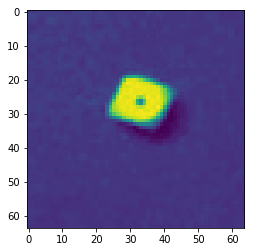

In [8]:
# show randomly chosen image
rows, cols = 64, 64
labels_values = 6
train_data = [data, label]
img=immatrix[53].reshape(rows, cols)
plt.imshow(img)
plt.show()

In [9]:
(X, y) = (train_data[0], train_data[1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [10]:
# reshape to [color_layers][pixels_height][pixels_width], color_layers equal to 2 because photos are in GRAYSCALE
X_train = X_train.reshape(X_train.shape[0], 1, rows, cols).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, rows, cols).astype('float32')

# normalize to 0-1
X_train /= 255
X_test /= 255

print(X_train.shape, X_test.shape)

(806, 1, 64, 64) (202, 1, 64, 64)


In [11]:
# onehot
y_train = to_categorical(y_train, 6)
y_test = to_categorical(y_test, 6)
print(y_train.shape, y_test.shape)

(806, 6) (202, 6)


In [12]:
# apply checkpoints
filepath = 'model_dist-{epoch:02d}-{loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=256, verbose=1, callbacks=callbacks_list)

Train on 806 samples, validate on 202 samples
Epoch 1/10
806/806 [==============================] - 29s 36ms/step - loss: 6.6394 - acc: 0.1998 - val_loss: 2.0065 - val_acc: 0.2228
Epoch 2/10
806/806 [==============================] - 28s 35ms/step - loss: 2.0289 - acc: 0.2134 - val_loss: 1.5563 - val_acc: 0.2921
Epoch 3/10
806/806 [==============================] - 28s 35ms/step - loss: 1.5176 - acc: 0.3300 - val_loss: 1.4935 - val_acc: 0.3267
Epoch 4/10
806/806 [==============================] - 28s 35ms/step - loss: 1.4039 - acc: 0.4107 - val_loss: 1.3977 - val_acc: 0.4109
Epoch 5/10
806/806 [==============================] - 28s 35ms/step - loss: 1.3113 - acc: 0.4206 - val_loss: 1.2999 - val_acc: 0.3762
Epoch 6/10
806/806 [==============================] - 28s 35ms/step - loss: 1.2671 - acc: 0.4231 - val_loss: 1.2754 - val_acc: 0.3564
Epoch 7/10
806/806 [==============================] - 28s 35ms/step - loss: 1.1919 - acc: 0.4504 - val_loss: 1.2232 - val_acc: 0.4257
Epoch 8/10
806/8

In [13]:
score = model.evaluate(X_test, y_test, verbose=1)

202/202 [==============================] - 4s 19ms/step


In [14]:
print('training results:')
for i in range(len(model.metrics_names)):
    print(str(model.metrics_names[i]) + ": " + str(score[i]))

training results:
loss: 1.05839460203
acc: 0.509900991279


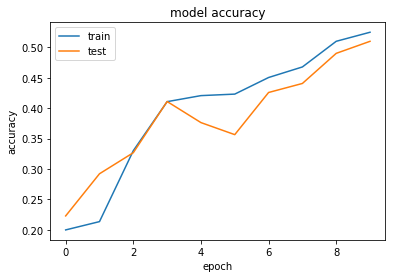

In [15]:
#summarize for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

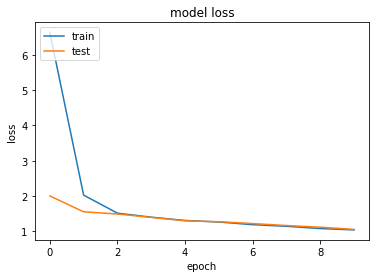

In [16]:
#summarize for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
model_json = model.to_json()
with open('model_dist.json', 'w') as json_file:
    json_file.write(model_json)
    
model.save_weights('dice_dist_weights.h5')
print('Saved model weights')

Saved model weights
